In [1]:
import os
import sys

try:
    import pyspark
except ImportError:
    import findspark
    findspark.init()
    import pyspark
    
    
# give notebook access to crymepipelines app modules
CRYMEPIPELINES_PATH = '/home/ben/.envs/cc/CrymeClarity/crymepipelines/src'
sys.path.insert(0, CRYMEPIPELINES_PATH)

#build spark session
APP_NAME = 'CRYME_PIPELINE_DEV'
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()


In [143]:
# import cyrmepipelines app modules
import csv
from datetime import datetime, timedelta
import os
import pickle as p
import shutil
import pandas as pd
from sklearn.metrics import log_loss
import numpy as np

from shared.objects.samples import SamplesManager
from shared.settings import CF_TRUST_DELAY, START_DATE, cf_conn, cp_conn, TMP_DIR, BIN_DIR
from tasks.base import SparkCrymeTask, NativeCrymeTask
from utils import crime_occ_udf, ts_to_minutes_in_day_udf, ts_to_hour_of_day_udf, ts_to_day_of_week_udf, ts_conv, safety_rel_crimes
from tasks.mixins import SearchForCrimesMixin


In [144]:
features = ['longitude', 'latitude', 'time_minutes']
target = 'crime_occ'

df = pd.read_csv(CRYMEPIPELINES_PATH + '/tmp/eval_dataset.csv')


In [145]:
df = pd.read_csv(CRYMEPIPELINES_PATH + '/tmp/eval_dataset.csv')
df['day'] = df.timestamp.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
clf = p.load(open(CRYMEPIPELINES_PATH + '/../bin/cryme_classifier_2019-05-25_n_ab.p', 'rb'))

In [146]:
features = ['longitude', 'latitude', 'time_minutes']


In [147]:
preds = clf.predict_proba(df[features])
df['preds_neg'] = preds[:, 0]
df['preds_pos'] = preds[:, 1]
df['log_loss'] = -1 * ((1 - df.n_ab) * np.log(df.preds_neg) + (df.n_ab) * np.log(df.preds_pos))
df.loc[:, 'log_loss'] = df.log_loss.fillna(0)

/home/ben/.envs/cc/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


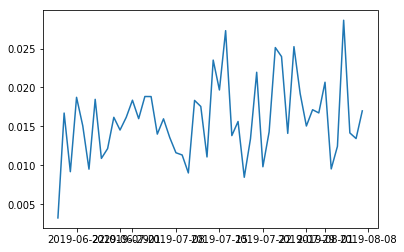

In [148]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(df.groupby('day').log_loss.mean())

In [149]:
df.columns

Index(['id', 'latitude', 'longitude', 'timestamp', 'lat_bb', 'lon_bb',
       'timestamp_unix', 'n_ab', 'n_b', 'n_t', 'n_btv', 'n_vbbs', 'n_pdt',
       'n_ltvc', 'n_sp', 'n_mio', 'n_r', 'time_minutes', 'day_of_week', 'day',
       'preds_neg', 'preds_pos', 'log_loss'],
      dtype='object')

In [150]:
df = df.groupby('day').log_loss.mean().reset_index()

In [155]:
str(df.values[0][0])

'2019-06-19'